In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.datasets import load_breast_cancer,load_iris,load_wine
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pydot
%matplotlib inline

In [3]:
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
target = pd.Series(data.target)
print(data.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [4]:
print('The shape of the dataset is ',df.shape)

The shape of the dataset is  (569, 30)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    df, 
    target,
    test_size=0.33, # ratio of data that is used for testing
    random_state=42, # setting random seed 
    stratify = target # Keeps the ratio of the labels in train and test the same as in the initial data
)

In [6]:
n_feature = len(data.feature_names)
rf = RandomForestClassifier(
    n_estimators=200, # Number of Trees grown
    max_features=min(10,n_feature), # Number of randomly picked features for split 
    max_depth=3, # Max Number of nested splits
    random_state=42, # Seed for random number generator
    #oob_score=True, # Out of Bag accuracy score
    #bootstrap=True # 
)
rf.fit(X_train,y_train)
print('The train accuracy: %.4f'%rf.score(X_train,y_train))
print('The test accuracy: %.4f'%rf.score(X_test,y_test))
pd.DataFrame(confusion_matrix(y_test, rf.predict(X_test)), index=data.target_names, columns=data.target_names)

The train accuracy: 0.9895
The test accuracy: 0.9415


,malignant,benign
malignant,64,6
benign,5,113


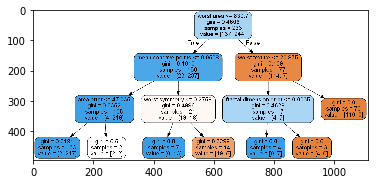

In [7]:
for i in np.arange(10):
    tree = rf.estimators_[i]
    export_graphviz(
        tree, 
        out_file='tree.dot',
        feature_names=list(X_train.columns),
        rounded=True,
        precision=4,
        filled=True
    )
    (graph,) = pydot.graph_from_dot_file('tree.dot')
    graph.set_bgcolor('transparent')
    graph.write_png('RF_one_tree_no_%i.png'%i)
img = mpimg.imread('RF_one_tree_no_%i.png'%i)
plt.imshow(img)
plt.show(block=False)

In [8]:
tree = rf.estimators_[0]
print('The train accuracy: %.4f'%tree.score(X_train,y_train))
print('The test accuracy: %.4f'%tree.score(X_test,y_test))
pd.DataFrame(confusion_matrix(y_test, tree.predict(X_test)), index=data.target_names, columns=data.target_names)

The train accuracy: 0.9580
The test accuracy: 0.9096


,malignant,benign
malignant,61,9
benign,8,110


In [9]:
tree = rf.estimators_[2]
print('The train accuracy: %.4f'%tree.score(X_train,y_train))
print('The test accuracy: %.4f'%tree.score(X_test,y_test))
pd.DataFrame(confusion_matrix(y_test, tree.predict(X_test)), index=data.target_names, columns=data.target_names)

The train accuracy: 0.9711
The test accuracy: 0.9149


,malignant,benign
malignant,64,6
benign,10,108


# Plotting feature importance

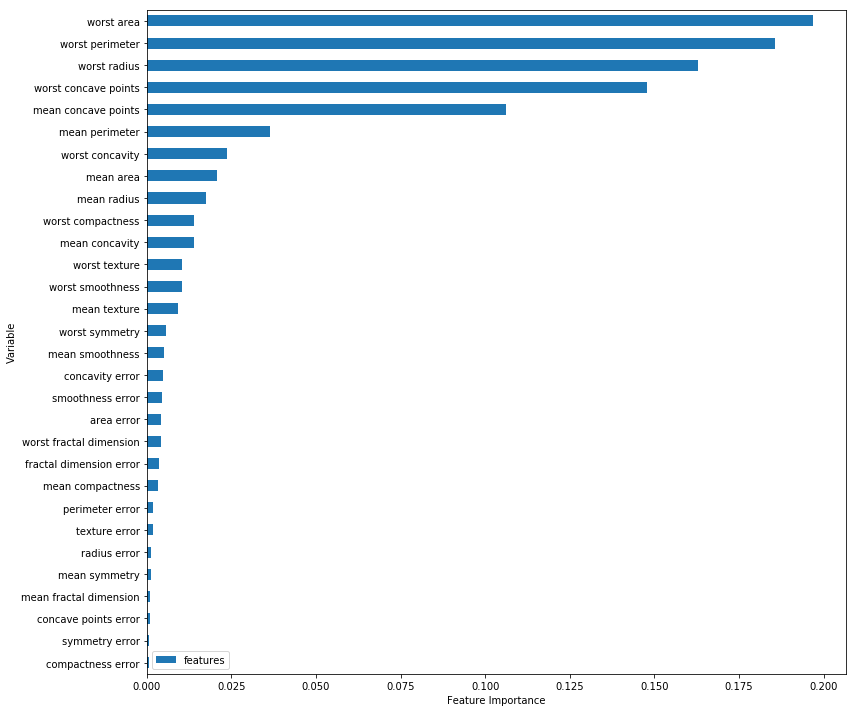

In [10]:
feature_imp = pd.DataFrame(rf.feature_importances_,index=df.columns,columns=['features']).sort_values('features')
ax = feature_imp.plot(kind='barh', figsize=(12, 10), zorder=2)
plt.xlabel('Feature Importance')
plt.ylabel('Variable')
plt.tight_layout()
plt.savefig('RF_feature_importance.png', dpi=600, transparent=True)

# Fitting Random Forrest for 2 most important features and plotting decision

In [11]:
s = 100
lab = list(feature_imp.sort_values('features',ascending=False)[:2].index)
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    max_depth=3
)
rf.fit(X_train[lab],y_train)
print('The train accuracy: %.4f'%rf.score(X_train[lab],y_train))
print('The test accuracy: %.4f'%rf.score(X_test[lab],y_test))
pd.DataFrame(confusion_matrix(y_test, rf.predict(X_test[lab])), index=data.target_names, columns=data.target_names)

The train accuracy: 0.9449
The test accuracy: 0.9202


,malignant,benign
malignant,60,10
benign,5,113


In [12]:
r = abs(X_train.max() - X_train.min())
x_min = X_train.min() - r * 0.1
x_max = X_train.max() + r * 0.1
r /= s

xx, yy = np.meshgrid(
    np.arange(x_min[lab[0]], x_max[lab[0]], r[lab[0]]), 
    np.arange(x_min[lab[1]], x_max[lab[1]], r[lab[1]])
)

In [13]:
n_classes = len(set(data.target))
if n_classes == 2:
    colors = ['b','r']
elif n_classes == 3:
    colors = ['b','g','r']
else:
    import matplotlib.cm as cm
    cmap = cm.get_cmap('rainbow', n_classes)    # PiYG
    colors = [cmap(i) for i in range(cmap.N)]

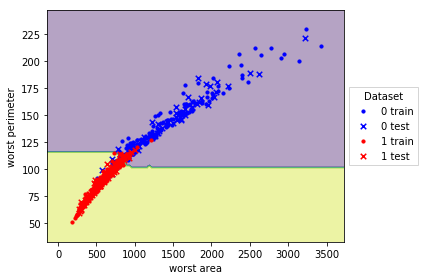

In [14]:
plt.figure()
ax = plt.gca()
Z = rf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax.contourf(xx, yy, Z, alpha=.4)
for b in set(y_train):
    idx = y_train == b

    ax.scatter(
        X_train.loc[idx,lab[0]], X_train.loc[idx,lab[1]], 
       c=np.array(colors)[b], 
        s=10,
        label='%i train'%b
    )
    idx2 = y_test == b
    ax.scatter(
        X_test.loc[list(idx2),lab[0]], X_test.loc[list(idx2),lab[1]],
        c=np.array(colors)[b],
        marker='x',
        s=30,
        label='%i test'%b
    )
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
plt.xlabel(lab[0])
plt.ylabel(lab[1])
plt.legend(
    loc='center left',bbox_to_anchor=(1,0.5), title='Dataset',
    fancybox=False
)
plt.tight_layout()
plt.savefig('RF_contour.png',dpi=300,transparent=True)
plt.show()

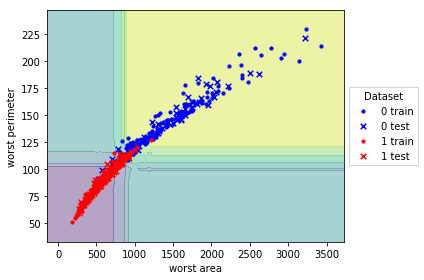

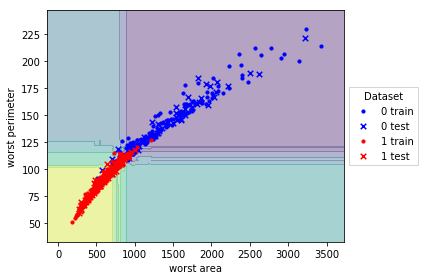

In [15]:
for cl in range(n_classes):
    plt.figure()
    ax = plt.gca()
    Z = rf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,cl]
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=.4)
    for b in set(y_train):
        idx = y_train == b

        ax.scatter(
            X_train.loc[idx,lab[0]], X_train.loc[idx,lab[1]], 
           c=np.array(colors)[b], 
            s=10,
            label='%i train'%b
        )
        idx2 = y_test == b
        ax.scatter(
            X_test.loc[list(idx2),lab[0]], X_test.loc[list(idx2),lab[1]],
            c=np.array(colors)[b],
            marker='x',
            s=30,
            label='%i test'%b
        )
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    plt.xlabel(lab[0])
    plt.ylabel(lab[1])
    plt.legend(
        loc='center left',bbox_to_anchor=(1,0.5), title='Dataset',
        fancybox=False
    )
    plt.tight_layout()
    plt.savefig('RF_contour_prob_class_%i.png'%cl,dpi=300,transparent=True)
    plt.show()

# Comparison

In [16]:
## Accuracy vs number of trees

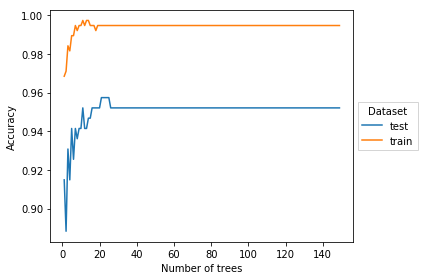

In [17]:
rf = RandomForestClassifier(
    n_estimators=200, # Number of Trees grown
    max_features=min(10,n_feature), # Number of randomly picked features for split 
    max_depth=5, # Max Number of nested splits
    random_state=42,
)
res = []
for i in range(1,150,1):
    rf.n_estimators = i
    rf.fit(X_train,y_train)
    d = dict({'n_estimators':i})
    d.update({'train':rf.score(X_train,y_train)})
    d.update({'test':rf.score(X_test,y_test)})
    res.append(d)
res = pd.DataFrame(res)
res.plot('n_estimators')
plt.ylabel('Accuracy')
plt.xlabel('Number of trees')
plt.legend(loc='center left',bbox_to_anchor=(1,0.5), title='Dataset',fancybox=False)
plt.savefig('RF_accuracy_number_of_trees.png',dpi=300,transparent=True)
plt.tight_layout()
plt.show()

In [18]:
## Accuracy vs number of samples per leaf

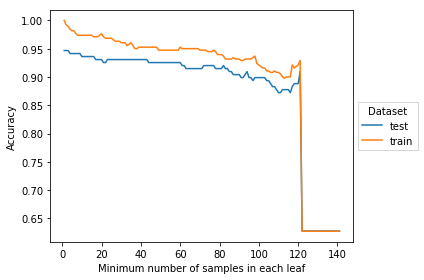

In [19]:
rf = RandomForestClassifier(
    n_estimators=500,
    max_features=min(10,n_feature),
    min_samples_leaf=1,
    random_state=42,
)
min_sample_class = min([sum(y_train==i) for i in set(y_train)])
res = []
for i in range(1,min_sample_class):
    rf.min_samples_leaf = i
    rf.fit(X_train,y_train)
    d = dict({'min_samples_leaf':i})
    d.update({'train':rf.score(X_train,y_train)})
    d.update({'test':rf.score(X_test,y_test)})
    res.append(d)
res = pd.DataFrame(res)
res.plot('min_samples_leaf')
plt.ylabel('Accuracy')
plt.xlabel('Minimum number of samples in each leaf')
plt.legend(loc='center left',bbox_to_anchor=(1,0.5), title='Dataset',fancybox=False)
plt.savefig('RF_accuracy_number_of_samples_per_leaf.png',dpi=300,transparent=True)
plt.tight_layout()
plt.show()

In [21]:
## Accuracy vs maximum features

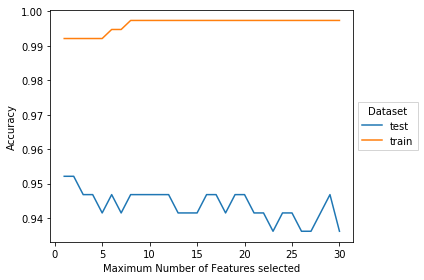

In [22]:
rf = RandomForestClassifier(
    n_estimators=500,
    max_features=min(10,n_feature),
    random_state=42,
    max_depth=5
)
res = []
for i in range(1,X_train.shape[1]+1):
    rf.max_features = i
    rf.fit(X_train,y_train)
    d = dict({'max_features':i})
    d.update({'train':rf.score(X_train,y_train)})
    d.update({'test':rf.score(X_test,y_test)})
    res.append(d)
res = pd.DataFrame(res)
res.plot('max_features')
plt.ylabel('Accuracy')
plt.xlabel('Maximum Number of Features selected')
plt.legend(loc='center left',bbox_to_anchor=(1,0.5), title='Dataset',fancybox=False)
plt.savefig('RF_accuracy_number_of_features.png',dpi=300,transparent=True)
plt.tight_layout()
plt.show()